In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import glob

from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init

import torchvision.datasets as dset

import torchvision.transforms as transforms

from torch.utils.data import DataLoader,TensorDataset

print(torch.__version__)

1.5.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
batch_size = 256
learning_rate = 0.0001
num_epoch = 20

airplane  :
 (151623, 28, 28)
axe  :
 (124122, 28, 28)
bicycle  :
 (126527, 28, 28)
bread  :
 (120570, 28, 28)
car  :
 (182764, 28, 28)
cup  :
 (130721, 28, 28)
spoon  :
 (125028, 28, 28)
tree  :
 (144721, 28, 28)


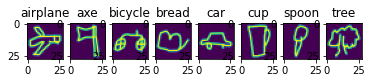

In [ ]:
num_file = 0
NN_list = []
scorecard = []
title_index = {}
index_title = {}
categories = []
test_data = torch.empty(9)

for image_file_path in glob.glob('/gdrive/My Drive/Colab Notebooks/Project/dataSet/*.npy'):
    data = np.load(image_file_path)
    image_title = image_file_path[49:-4]  # image_title => original title


    title_index[image_title] = num_file    # title_index  => key : original title, value : index
    index_title[num_file]    = image_title
    categories.append(image_title)        # categories  => list of original title  
    num_file += 1



classes = {}
t = 1
for category in categories:
    data_ = np.load("/gdrive/My Drive/Colab Notebooks/Project/dataSet/" + category + ".npy")
    data_ = data_.reshape(-1,28,28)
    print(category," :\n",data_.shape)
    #print(data_.shape)
    
    classes[category] = data_
    #print(data_.shape)
    

for i in range(num_file):
  
  plt.subplot(1,num_file, i+1)
  plt.imshow(classes[index_title[i]][0])
  plt.title(index_title[i])

plt.show()

# **Combine and separate -value(image) , keys(index)-**

In [ ]:
values = []
keys = []

for key, value in classes.items():
    #  print(np.shape(value))
    #  print(np.shape(key))
     
     for i in range(len(value)):
       values.append(value[i])
       keys.append(int(title_index[key]))


# **Combine data in DataLoader**

In [ ]:
image_train_, image_test_, label_train_, label_test_ = train_test_split(values, keys, test_size=0.1, random_state=1)

image_train = torch.from_numpy(np.array(image_train_)).float()
image_test = torch.from_numpy(np.array(image_test_)).float()
label_train = torch.from_numpy(np.array(label_train_))
label_test = torch.from_numpy(np.array(label_test_))

#print(image_train.shape)
#print(label_train.shape)

image_train = image_train.view(-1,1,28,28)    # 데이터 형식 맞춰주기
image_test = image_test.view(-1,1,28,28)


print("Image_train :\n",image_train.shape)
print("Label_train :\n",label_train.shape)
print("Image_test :\n",image_test.shape)
print("Label_test :\n",label_test.shape)


train_dataset = TensorDataset(image_train, label_train)   # DataLoader로 묶기
test_dataset = TensorDataset(image_test, label_test)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2,drop_last=True)
test_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)


Image_train :
 torch.Size([995468, 1, 28, 28])
Label_train :
 torch.Size([995468])
Image_test :
 torch.Size([110608, 1, 28, 28])
Label_test :
 torch.Size([110608])


# **CNN model**

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=16,kernel_size=5),             # [batch_size,1,28,28] -> [batch_size,16,24,24]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16,out_channels=32,kernel_size=5),            # [batch_size,16,24,24] -> [batch_size,32,20,20]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),                               # [batch_size,32,20,20] -> [batch_size,32,10,10]
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),          # [batch_size,32,10,10] -> [batch_size,64,6,6]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)                                # [batch_size,64,6,6] -> [batch_size,64,3,3]
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(64*3*3,100),                                              # [batch_size,64*3*3] -> [batch_size,100]
            nn.ReLU(),
            nn.Linear(100,num_file)                                             # [batch_size,100] -> [batch_size,8]
        )       
        
    def forward(self,x):
        out = self.layer(x)                                                     
        out = out.view(batch_size,-1)                                           
                                                                                
        out = self.fc_layer(out)
        return out

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = CNN().to(device)

loss_func = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


In [ ]:
for i in model.named_children():
    print(i)

('layer', Sequential(
  (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
))
('fc_layer', Sequential(
  (0): Linear(in_features=576, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=8, bias=True)
))


In [ ]:
loss_arr =[]
Accuracy_arr = []
Improved_arr = []
recect_Accuracy = 0

print("Num of outputs :", num_file ,"\n")
for i in range(num_epoch):

    for j,[image,label] in enumerate(train_loader):
        x = image.to(device)
        y_= label.to(device)

        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j  == int(len(image_train)/batch_size) - 1:
            print("epoch No :", i+1)  
            print("Loss     :", round(float(loss.cpu().detach().numpy()),4))
            loss_arr.append(loss.cpu().detach().numpy())
            correct = 0
            total = 0

            with torch.no_grad():

              for image,label in test_loader:
                  x = image.to(device)
                  y_= label.to(device)
                  
                  output = model.forward(x)
                  _,output_index = torch.max(output,1)
                  total += label.size(0)        
                  correct += (output_index == y_).sum().float()

            print("Accuracy :", round( float(format(100*correct/total)) ,4) )
            Accuracy_arr.append(float(format(100*correct/total)))
            
            Improved = float(format(100*correct/total)) - recect_Accuracy
            print("Improved :", round(Improved,4), "%\n" )
            recect_Accuracy = float(format(100*correct/total))
            Improved_arr.append(Improved)

            


Num of outputs : 8 

epoch No : 1
Loss     : 0.115
Accuracy : 95.1371
Improved : 95.1371 %

epoch No : 2
Loss     : 0.1614
Accuracy : 95.6462
Improved : 0.5091 %

epoch No : 3
Loss     : 0.134
Accuracy : 96.0721
Improved : 0.4259 %

epoch No : 4
Loss     : 0.0565
Accuracy : 96.0928
Improved : 0.0208 %

epoch No : 5
Loss     : 0.1451
Accuracy : 96.2502
Improved : 0.1573 %

epoch No : 6
Loss     : 0.1802
Accuracy : 96.243
Improved : -0.0072 %

epoch No : 7
Loss     : 0.1886
Accuracy : 96.3153
Improved : 0.0723 %

epoch No : 8
Loss     : 0.1329
Accuracy : 96.4247
Improved : 0.1094 %

epoch No : 9
Loss     : 0.0961
Accuracy : 96.4202
Improved : -0.0045 %

epoch No : 10
Loss     : 0.0808
Accuracy : 96.4699
Improved : 0.0497 %

epoch No : 11
Loss     : 0.1456
Accuracy : 96.5432
Improved : 0.0732 %

epoch No : 12
Loss     : 0.0581
Accuracy : 96.4844
Improved : -0.0588 %

epoch No : 13
Loss     : 0.1638
Accuracy : 96.4482
Improved : -0.0362 %

epoch No : 14
Loss     : 0.0693
Accuracy : 96.5115

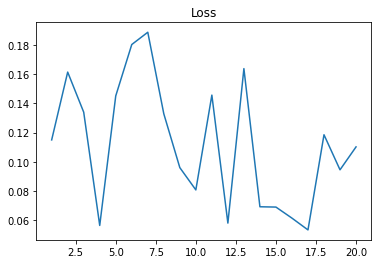

In [ ]:
plt.plot(range(1,num_epoch+1),loss_arr)
plt.title("Loss")
plt.show()

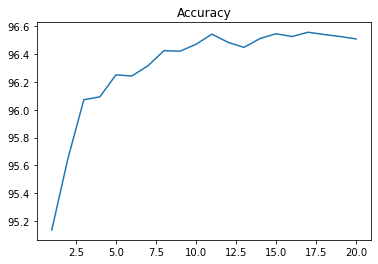

In [ ]:
plt.plot(range(1,num_epoch+1),Accuracy_arr)
plt.title("Accuracy")
plt.show()

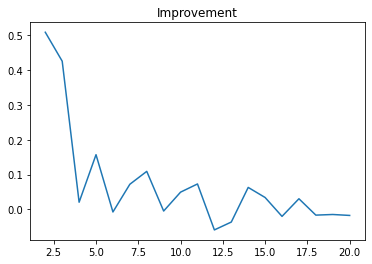

In [ ]:
plt.plot(range(2,num_epoch+1),Improved_arr[1:])
plt.title("Improvement")
plt.show()